# "Selective Mask"
> "How to select certain aspects of a mask for viewing and for loading into a `DataBlock`"
- toc: true
- branch: master
- badges: true
- comments: true
- categories: [medical_imaging, prostate, kaggle, segmentation]
- image: images/msk.PNG

## Goal:

The goals of this notebook are to:
- look through how to select specify masks for an image
- how to get the selective mask ready for the `DataBlock`
- based on the dataset from this competition: [Prostate cANcer graDe Assessment (PANDA) Challenge](https://www.kaggle.com/c/prostate-cancer-grade-assessment) and you can view my kaggle [kernel](https://www.kaggle.com/avirdee/fastai2-selective-mask-map-isup-grades)

This notebook does not use `DICOMS`

For example:

### Original Mask
![selective_msk.PNG](my_icons/selective_msk.PNG)

### Selective Mask
![selective_msk2.PNG](my_icons/selective_msk2.PNG)

## Motivation

There more than 1 million new prostate cancer diagnoses reported every year, in fact prostate cancer is the second most common cancer among males worldwide that results in more than 350,000 deaths annually. Diagnosis of prostate cancer is based on the grading of prostate tissue biopsies. These tissue samples are examined by a pathologist and scored according to the Gleason grading system.

The grading process consists of finding and classifying cancer tissue into so-called Gleason patterns (3, 4, or 5) based on the architectural growth patterns of the tumor

![glee.PNG](my_icons/glee.PNG)
(picture: courtesy: Kaggle)

After the biopsy is assigned a Gleason score, it is converted into an ISUP grade on a 1-5 scale

## Dataset

The dataset consists of about 10,600 images and masks

In [2]:
#hide
#Load the dependancies
from fastai2.basics import *
from fastai2.callback.all import *
from fastai2.vision.all import *

import seaborn as sns
import numpy as np
import pandas as pd
import os
import cv2

sns.set(style="whitegrid")
sns.set_context("paper")

matplotlib.rcParams['image.cmap'] = 'ocean_r'

In [5]:
#hide
source = Path("D:/Datasets/prostate_png")
files = os.listdir(source)
train = source/'train_images'
mask = source/'train_label_masks'
train_labels = pd.read_csv(source/'train.csv')

In [18]:
#hide
def view_image(folder, fn):
    if folder == train:
        filename = f'{folder}/{fn}.png'
    if folder == mask:
        filename = f'{folder}/{fn}_mask.png'
    file = Image.open(filename)
    t = tensor(file)
    if folder == train:
        show_image(t)
    if folder == mask:
        show_image(t[:,:,2])

Lets view an image

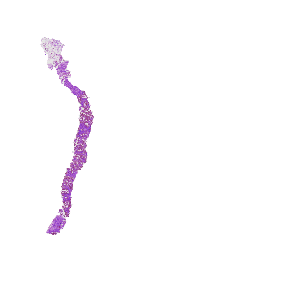

In [19]:
view_image(train, '0005f7aaab2800f6170c399693a96917')

And the corresponding mask

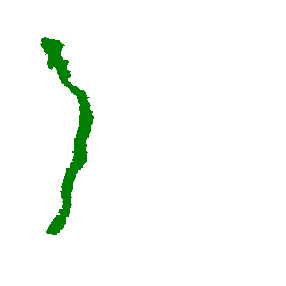

In [20]:
view_image(mask, '0005f7aaab2800f6170c399693a96917')

The dataset is categorized by both isup_grade and gleason_score. What is noticed is that the masks have different intensities. For example we can specify a function that will display the image, the mask and plot a histogram of the intensites.

In [29]:
def view_images(file, mask, fn):
    ima = f'{file}/{fn}.png'
    msk = f'{mask}/{fn}_mask.png'
    ima_file = Image.open(ima); ima_t = tensor(ima_file)
    ima_msk = Image.open(msk); msk_t = tensor(ima_msk)
    
    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (20, 6))
    s1 = show_image(ima_t, ax=ax1, title='image')
    s2 = show_image(msk_t[:,:,2], ax=ax2, title='mask')
    s3 = plt.hist(msk_t.flatten()); plt.title('mask histogram')
    plt.show()

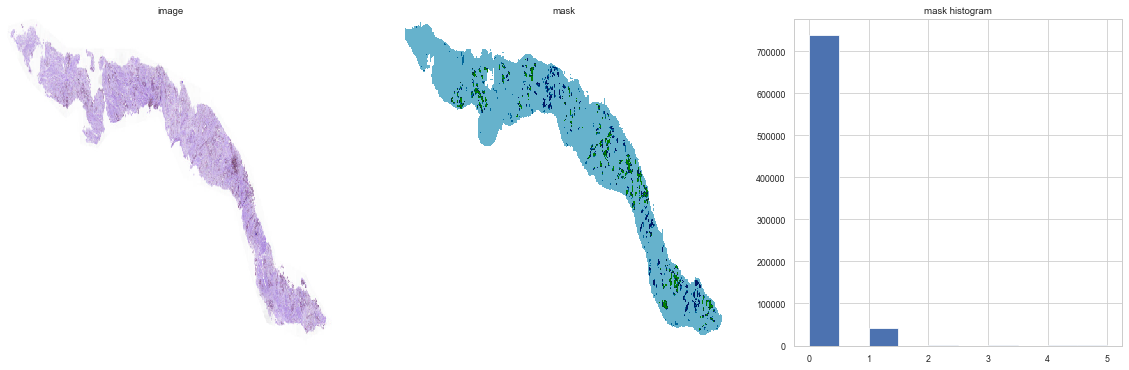

In [30]:
view_images(train, mask, '06636cdd43041e78141f2f5069fa62d5')

Plotting a histogram of the mask intensities shows that the bulk of the intensity is between 0 and 1 and this corresponds to the the bulk of the pixels which is the outline of the mask (light blue)

Here are some more examples

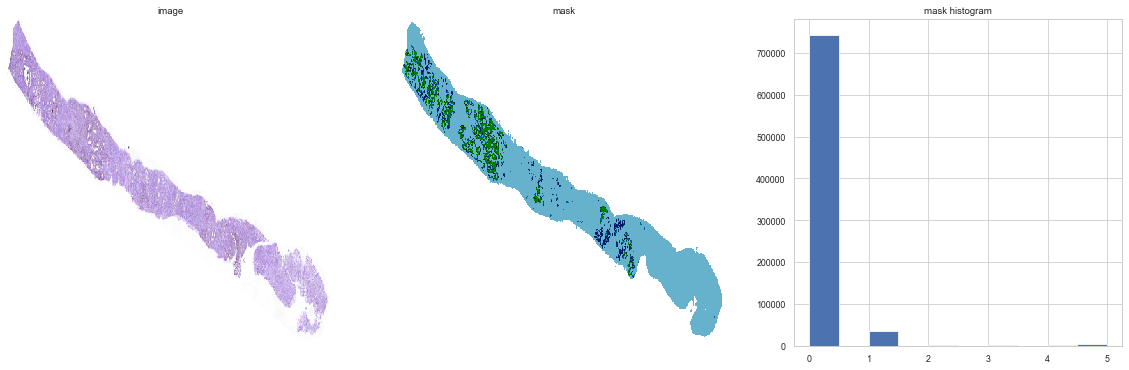

In [31]:
view_images(train, mask, '0d3159cd1b2495cc82637ececf63ed41')

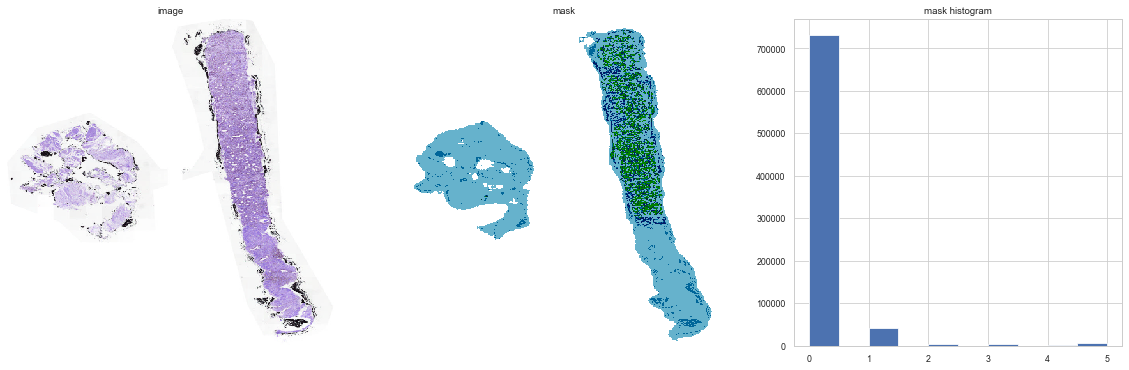

In [32]:
view_images(train, mask, '08134913a9aa1d541f719e9f356f9378')

Can see that the bulk of the pixels within the mask are the light blue areas of the mask which correspond to the the out outline of the mask itself.

## Selective Mask

To be able to view the mask images at different intensities I adapted a function from fastai's medical imaging library (which is typically geared towards working with DICOM images).

Load the medical imaging library

In [33]:
from fastai2.medical.imaging import *

This library has a show function that has the capability of specifying max and min pixel values so you can specify the range of pixels you want to view within an image (useful when DICOM images can vary in pixel values between the range of -32768 to 32768).

You can easily adapt any function in fastai2 using @patch and it just works! In this case I am adapting the show function so you can specify min and max pixel values for this dataset.

In [34]:
@patch
@delegates(show_image)
def show(self:PILImage, scale=True, cmap=plt.cm.ocean_r, min_px=None, max_px=None, **kwargs):
    px = tensor(self)
    if min_px is not None: px[px<min_px] = float(min_px)
    if max_px is not None: px[px>max_px] = float(max_px)
    show_image(px, cmap=cmap, **kwargs)

We will also have to define another function that will allow us to view the selective masks

In [38]:
def selective_mask(file, mask, fn, min_px=None, max_px=None):
    ima = f'{file}/{fn}.png'
    msk = f'{mask}/{fn}_mask.png'
    ima_file = Image.open(ima); ima_t = tensor(ima_file)
    ima_msk = Image.open(msk); msk_t = tensor(ima_msk)
    msk_pil = PILImage.create(msk_t[:,:,2])
    
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize = (20, 6))
    s1 = show_image(ima_t, ax=ax1, title='image')
    s2 = show_image(msk_t[:,:,2], ax=ax2, title='mask')
    s3 = msk_pil.show(min_px=min_px, max_px=max_px, ax=ax3, title=f'selective mask: min_px:{min_px}')
    s4 = plt.hist(msk_t.flatten()); plt.title('mask histogram')
    plt.show()

The plot shows the original image, the mask, the selective mask(in this case all intensities are shown hence the reason it looks the same as the mask image) and the histogram of intensities (again the bulk of pixels are within 0 and 1

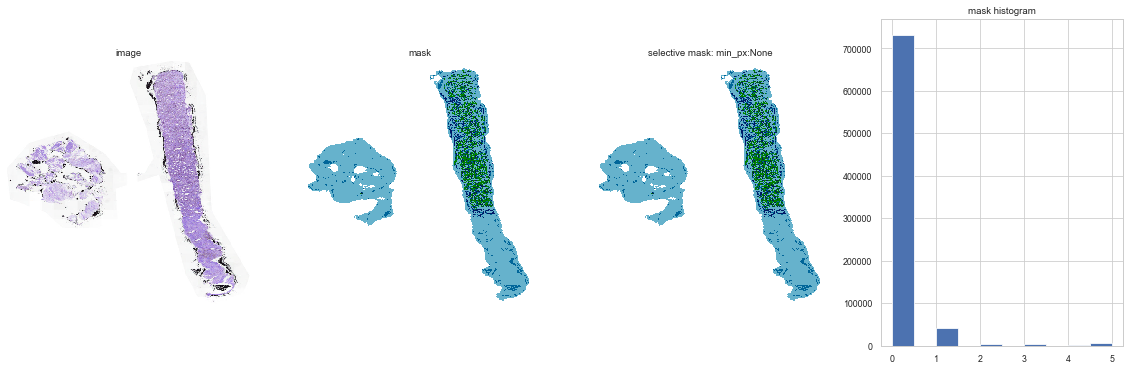

In [39]:
selective_mask(train, mask, '08134913a9aa1d541f719e9f356f9378', min_px=None, max_px=None)

How about intensities above 1 (so getting rid of the bulk of pixels)

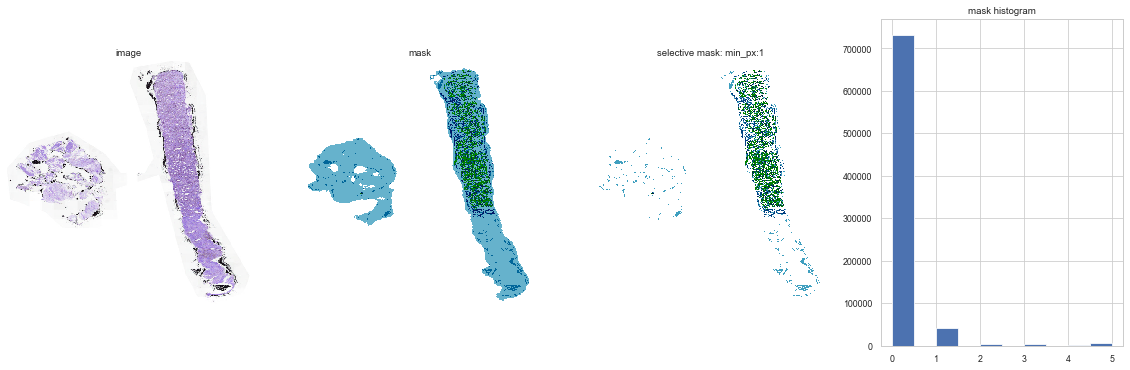

In [40]:
selective_mask(train, mask, '08134913a9aa1d541f719e9f356f9378', min_px=1, max_px=None)

Intensities above 2

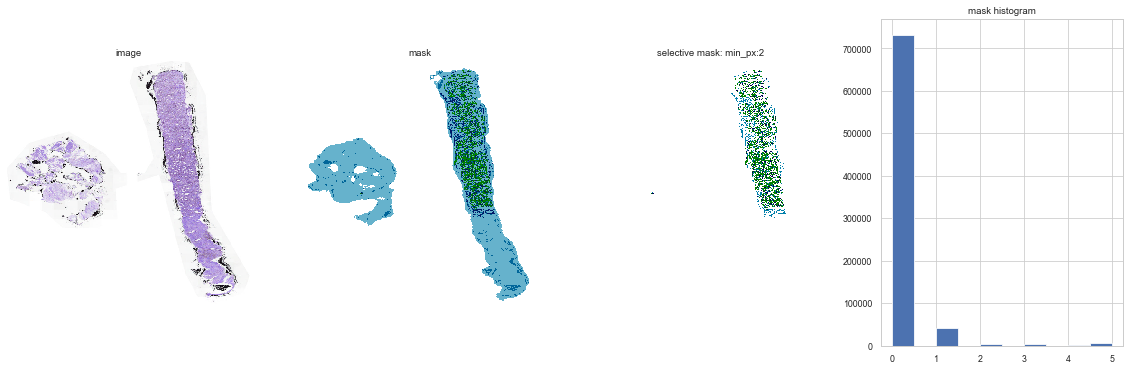

In [41]:
selective_mask(train, mask, '08134913a9aa1d541f719e9f356f9378', min_px=2, max_px=None)

Intensities above 3

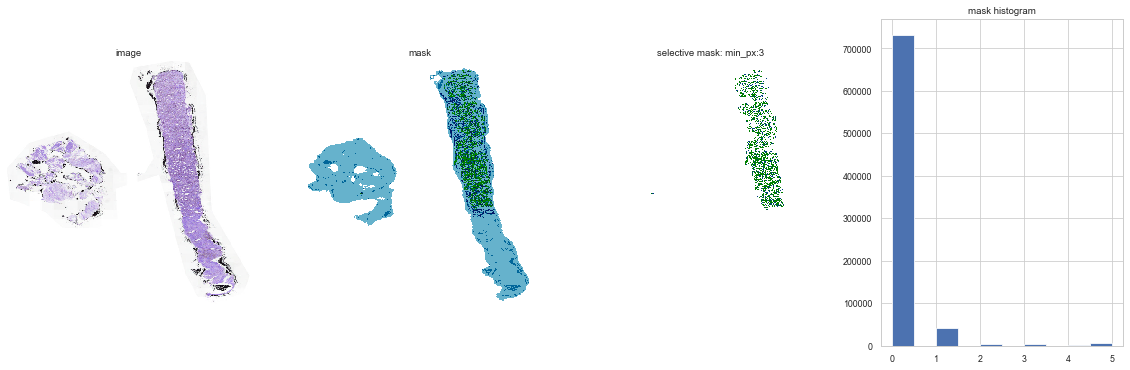

In [42]:
selective_mask(train, mask, '08134913a9aa1d541f719e9f356f9378', min_px=3, max_px=None)

The histogram does show some pixels above 4 but not many

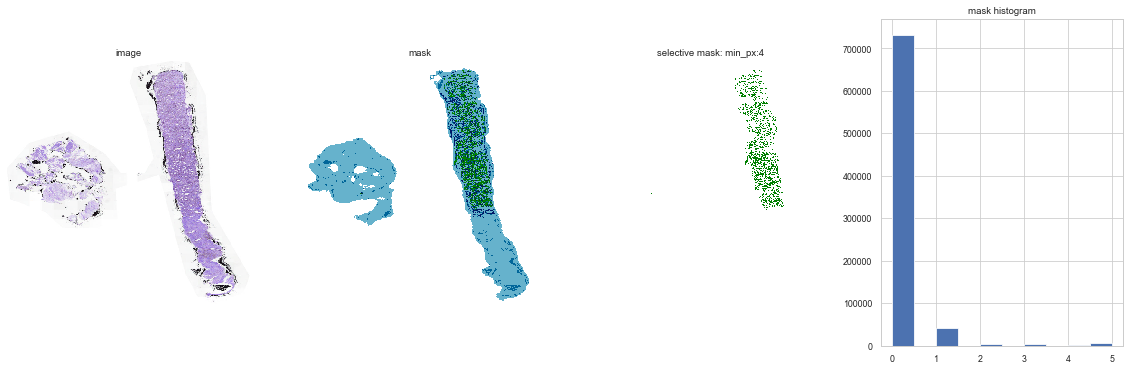

In [43]:
selective_mask(train, mask, '08134913a9aa1d541f719e9f356f9378', min_px=4, max_px=None)

Looking at the selective masks side by side

In [47]:
msk = f'{mask}/08134913a9aa1d541f719e9f356f9378_mask.png'
ima_msk = Image.open(msk); msk_t = tensor(ima_msk)
msk_pil = PILImage.create(msk_t[:,:,2])

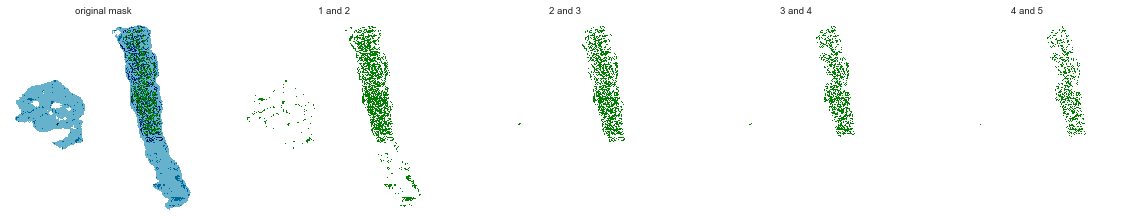

In [48]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5, figsize = (20, 6))
s1 = msk_pil.show(min_px=None, max_px=None, ax=ax1, title='original mask')
s2 = msk_pil.show(min_px=1, max_px=2, ax=ax2, title='1 and 2')
s3 = msk_pil.show(min_px=2, max_px=3, ax=ax3, title='2 and 3')
s4 = msk_pil.show(min_px=3, max_px=4, ax=ax4, title='3 and 4')
s4 = msk_pil.show(min_px=4, max_px=5, ax=ax5, title='4 and 5')
plt.show()

## Comparing masks from different isup grades

Lets check an example with isup_grade of 0

In [49]:
isup_0 = train_labels[train_labels.isup_grade == 0]
isup_0[:1]

,image_id,data_provider,isup_grade,gleason_score
0,0005f7aaab2800f6170c399693a96917,karolinska,0,0+0


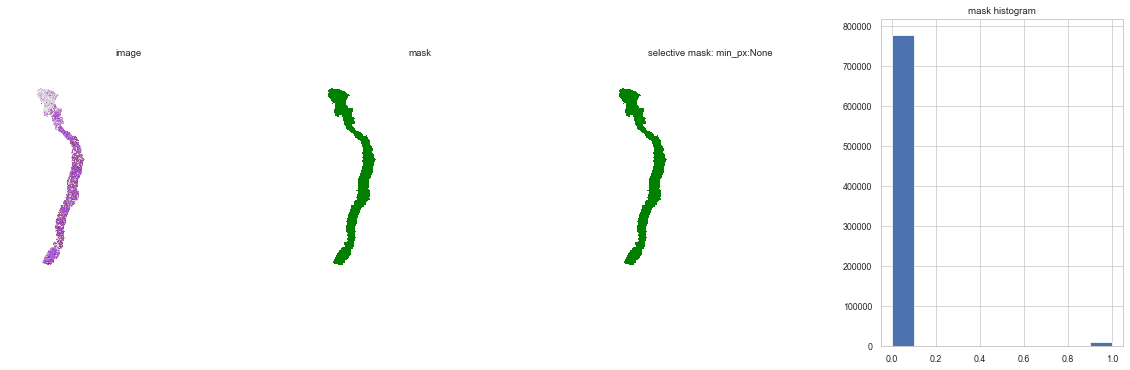

In [50]:
selective_mask(train, mask, '0005f7aaab2800f6170c399693a96917', min_px=None, max_px=None)

What about images with isup_grade of 5

In [51]:
isup_5 = train_labels[train_labels.isup_grade == 5]
isup_5[:1]

,image_id,data_provider,isup_grade,gleason_score
22,00928370e2dfeb8a507667ef1d4efcbb,radboud,5,4+5


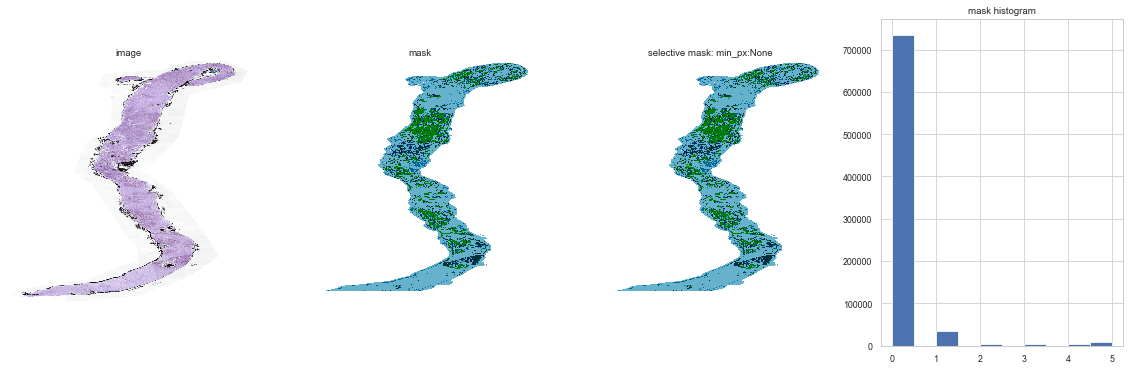

In [52]:
selective_mask(train, mask, '00928370e2dfeb8a507667ef1d4efcbb', min_px=None, max_px=None)

It looks like:

each mask has intensities based on its isup_grade

## DataBlock

Lets see what the dataBlock would look like. fastai provides a very convenient way of getting the dataset ready for training for example you can specify blocks and getters where blocks can be images, labels etc and getters are where are the images or labels located.

For this we would have to create 2 custom functions, one so that that the dataloader can correctly view the images (as they are in .tiff format and fastai does not have an out of the box method of parsing these files and the second so that we only view the masks in the red channel

As we'll be using the csv file to load the images

In [59]:
def custom_img(fn):
    fn = f'{train}/{fn.image_id}.png'
    file = Image.open(fn)
    t = tensor(file)
    img_pil = PILImage.create(t)
    return img_pil

For the masks

We have to make a custom function show_selective so that we can pass the different intensities to the dataloader

In [60]:
def show_selective(p, scale=True, cmap=plt.cm.ocean_r, min_px=None, max_px=None):
    px = tensor(p)
    if min_px is not None: px[px<min_px] = float(min_px)
    if max_px is not None: px[px>max_px] = float(max_px)
    return px

In [61]:
def custom_selective_msk(fn):
    fn = f'{mask}/{fn.image_id}_mask.png'
    file = Image.open(fn)
    t = tensor(file)[:,:,2]
    ts = show_selective(t, min_px=None, max_px=None)
    return ts

Specify the blocks

Lets look at images and masks side by side just to see what the images and masks look like

### Using Original Mask

In [62]:
blocks = (ImageBlock,
          ImageBlock)

getters = [
           custom_img,
           custom_selective_msk
          ]

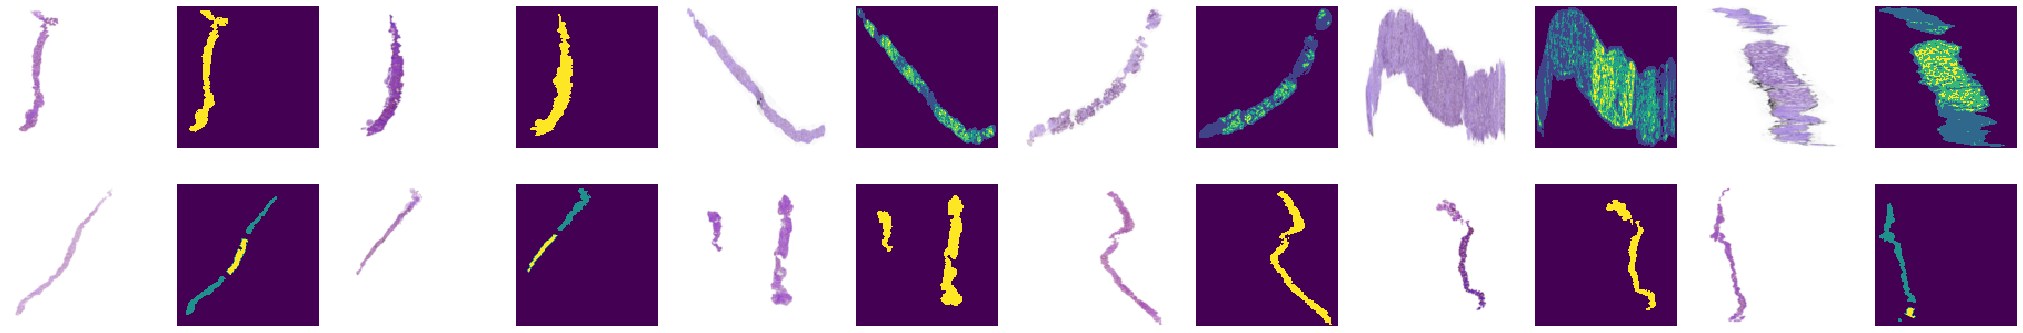

In [63]:
prostate = DataBlock(blocks=blocks,
                 getters=getters,
                 item_tfms=Resize(128))

j = prostate.dataloaders(train_labels, bs=16)
j.show_batch(max_n=12, nrows=2, ncols=6)

The batch above shows the images and masks side by side, in this case the full mask is being shown. However what if we specify the mask intensites, as an example I want to get rid of the bulk of images which is predominantly the outline of the mask or any intensitiy below 1

### Using Selective Mask

Specify the min_px value as 1 in the custom_selective_msk function:

In [64]:
def custom_selective_msk(fn):
    fn = f'{mask}/{fn.image_id}_mask.png'
    file = Image.open(fn)
    t = tensor(file)[:,:,2]
    ts = show_selective(t, min_px=1, max_px=None)
    return ts

In [65]:
blocks = (ImageBlock,
          ImageBlock)

getters = [
           custom_img,
           custom_selective_msk
          ]

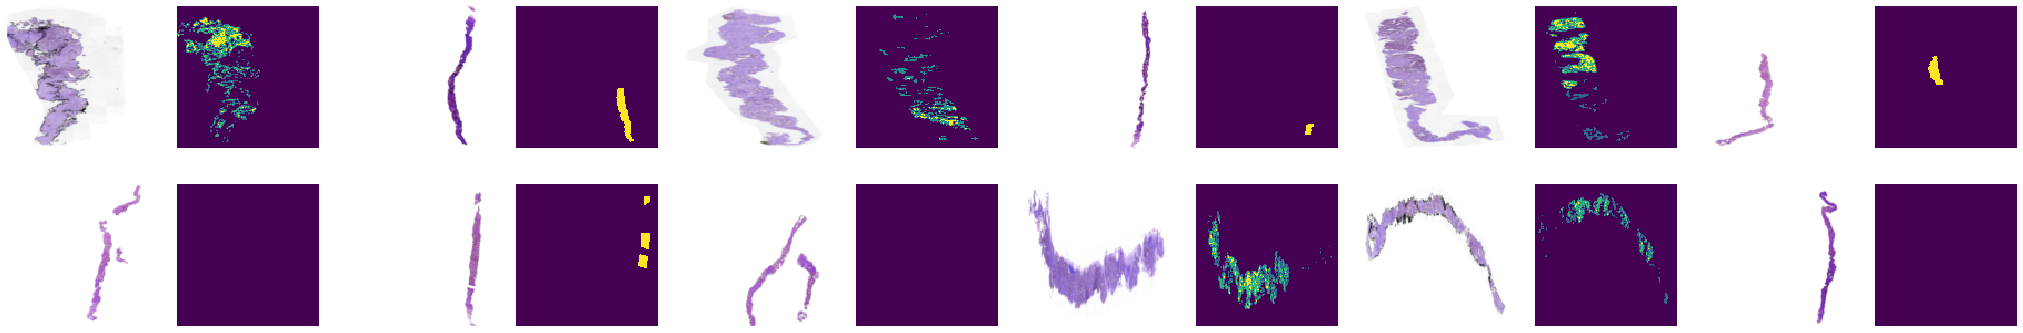

In [67]:
prostate = DataBlock(blocks=blocks,
                 getters=getters,
                 item_tfms=Resize(128))

j = prostate.dataloaders(train_labels, bs=16)
j.show_batch(max_n=12, nrows=2, ncols=6)

We can see that the mask images are selective. The mask images that are fully purple correspond to images that have an isup_grade of 0

Now lets look at the images and masks over-layed on each other. For this we simply change the ImageBlock we used above for the mask images into a MaskBlock and lets add a CategoryBlock so that we can identify the isup_grade

In [68]:
def custom_selective_msk(fn):
    fn = f'{mask}/{fn.image_id}_mask.png'
    file = Image.open(fn)
    t = tensor(file)[:,:,2]
    ts = show_selective(t, min_px=None, max_px=None)
    return ts

In [69]:
blocks = (ImageBlock,
          MaskBlock,
          CategoryBlock)

getters = [
           custom_img,
           custom_selective_msk,
           ColReader('isup_grade')
          ]

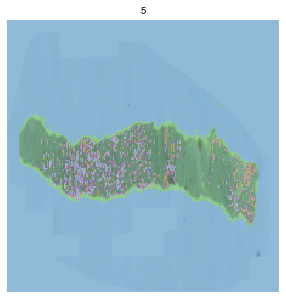

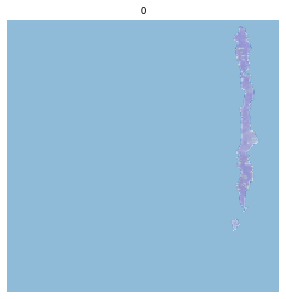

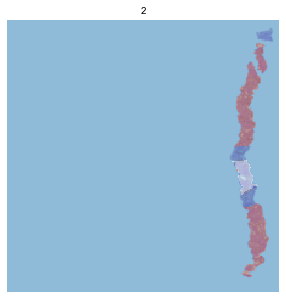

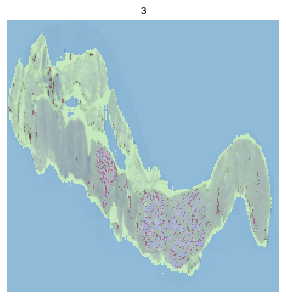

In [72]:
prostate = DataBlock(blocks=blocks,
                 getters=getters,
                 item_tfms=Resize(224))

j = prostate.dataloaders(train_labels, bs=16)
j.show_batch(max_n=4)